# Laboratorio 4: SHAP en un modelo cualquiera
Francisco Castillo - 21562

In [ ]:
import torch
from transformers import pipeline as model
from PIL import Image
import matplotlib.pyplot as plt
import os

In [22]:
pipeline = model(
    task="image-classification",
    model="google/mobilenet_v2_1.4_224",
    dtype=torch.float16,
    device=0 if torch.cuda.is_available() else -1,
)

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Device set to use cpu


In [23]:
# Images from https://github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes/tree/main/ILSVRC2012_img_val_subset
images_path = "data/"
num_files = len(os.listdir(images_path))
images = [
    Image.open(images_path + f"image_{i}.jpg")
    for i in range(1, num_files + 1)
]

In [24]:
k = 3

In [25]:
predictions = pipeline(images, top_k=k)

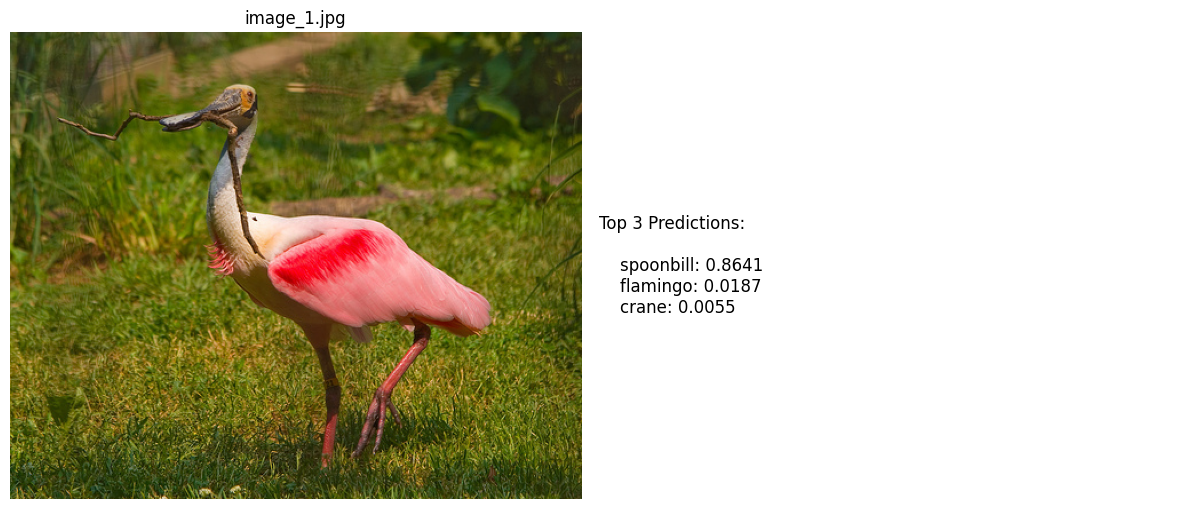

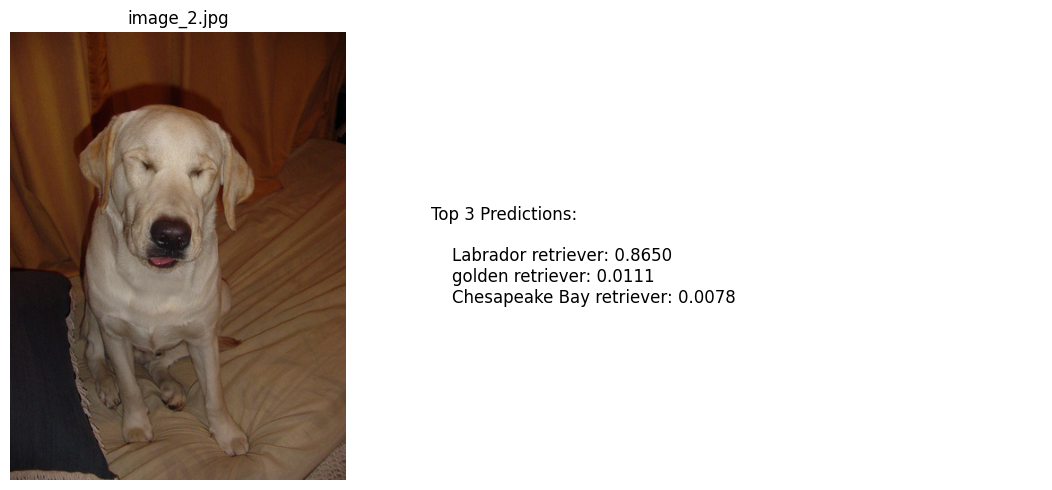

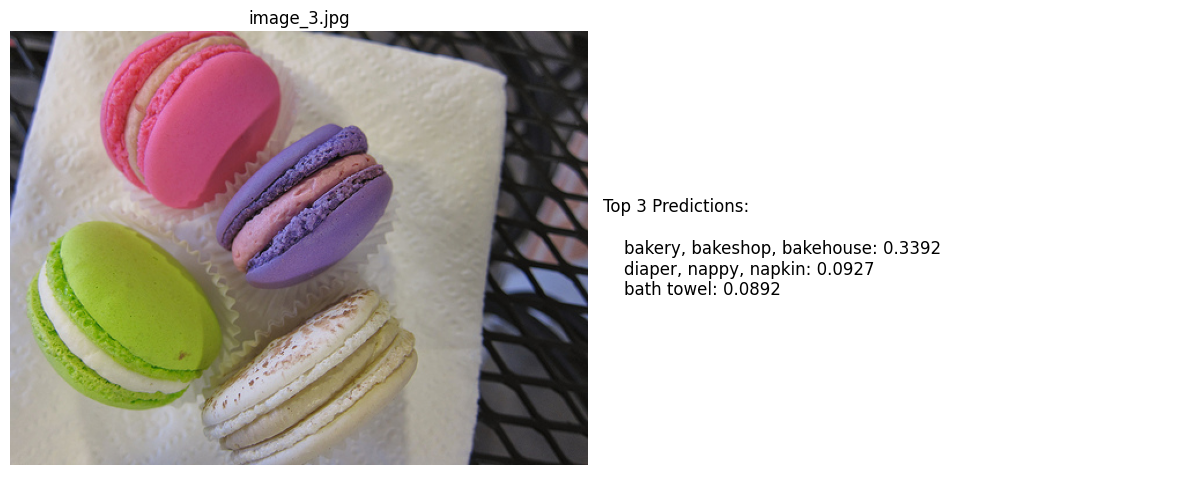

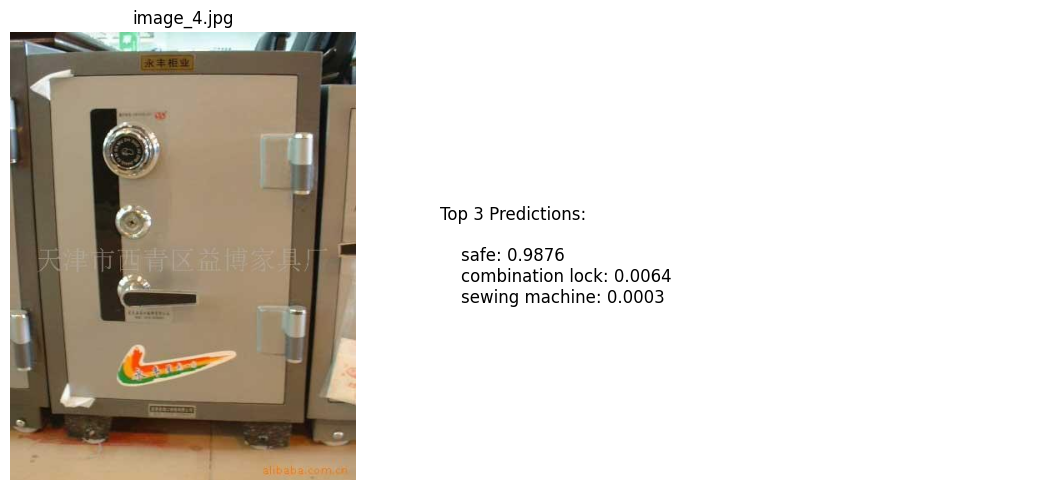

In [26]:
for i, (img, preds) in enumerate(zip(images, predictions), 1):
    # Create a figure with two subplots: one for the image, one for the text
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})

    # Display the image on the left subplot
    ax1.imshow(img)
    ax1.set_title(f"image_{i}.jpg")
    ax1.axis('off')

    # Prepare the prediction text
    pred_text = f"Top {k} Predictions:\n\n"
    # Replaced '\t' with spaces to avoid the UserWarning
    pred_text += "\n".join([f"    {p['label']}: {p['score']:.4f}" for p in preds])

    # Display the predictions as text on the right subplot
    ax2.text(0, 0.5, pred_text, ha='left', va='center', fontsize=12, wrap=True)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

PartitionExplainer explainer: 2it [12:13, 733.76s/it]              


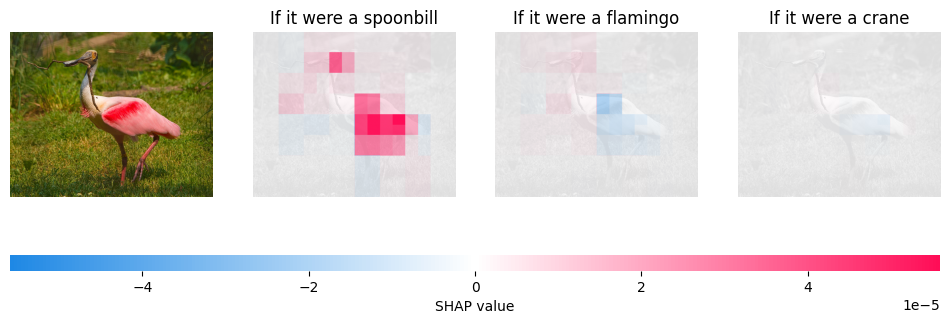

PartitionExplainer explainer: 2it [12:23, 743.56s/it]              


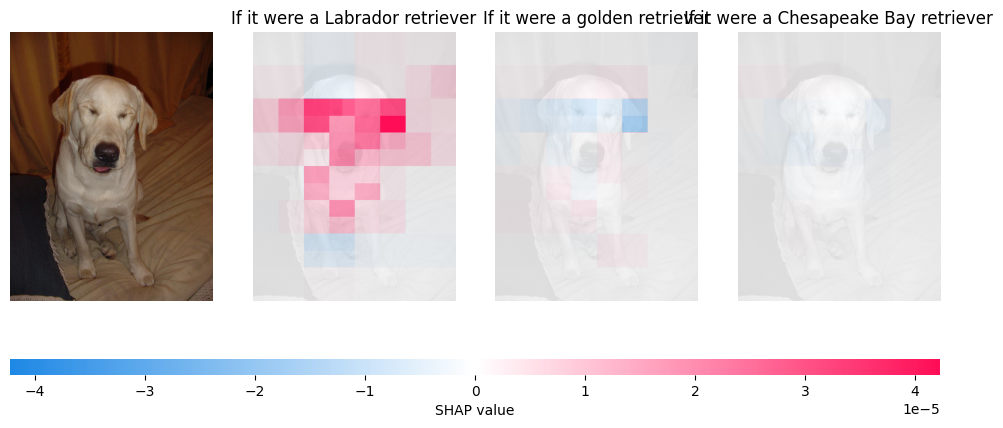

PartitionExplainer explainer: 2it [12:22, 742.93s/it]              


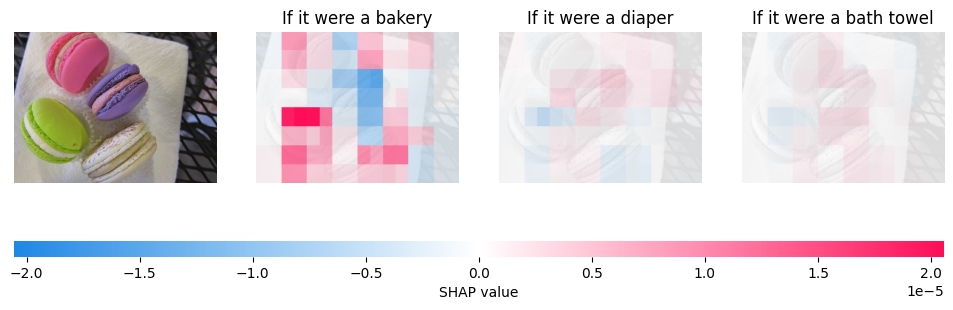

PartitionExplainer explainer: 2it [12:24, 744.85s/it]              


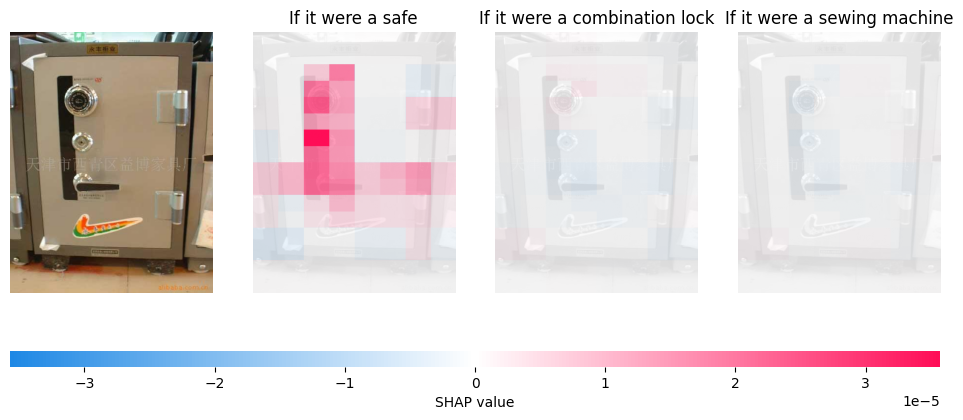

In [27]:
import numpy as np
import pandas as pd
import shap
from PIL import Image
from skimage.segmentation import slic
import matplotlib.pyplot as plt

def f(x):
    """
    Converts numpy arrays from SHAP back to PIL images for the pipeline
    and formats the model's output scores into a pandas DataFrame.
    """
    pil_images = [Image.fromarray(img.astype('uint8')) for img in x]
    predictions = pipeline(pil_images, top_k=k)
    scores = np.zeros((len(predictions), k))
    for i, pred_list in enumerate(predictions):
        for j, pred in enumerate(pred_list):
            scores[i, j] = pred['score']
    # Return scores as a pandas DataFrame to prevent a potential AttributeError
    return pd.DataFrame(scores)

for image_to_explain in images:
    image_np = np.array(image_to_explain)

    # The slic algorithm segments the image into superpixels.
    segments_slic = slic(image_np, n_segments=1000, compactness=10, sigma=1, start_label=1)

    # Create an Image masker with a blur effect.
    masker = shap.maskers.Image("blur(128,128)", image_np.shape)

    # Create an explainer object with the custom segmentation.
    explainer = shap.Explainer(f, masker, clustering=segments_slic)

    # Calculate SHAP values.
    shap_values = explainer(
        image_np[np.newaxis, ...],
        max_evals=500,
        batch_size=64
    )

    shap_values.data = image_np[np.newaxis, ...]

    # Get top predictions for plot titles.
    original_preds = pipeline([image_to_explain], top_k=k)[0]
    class_labels = [pred['label'] for pred in original_preds]
    formatted_labels = [f"If it were a {label.split(', ')[0]}" for label in class_labels]

    # Visualize the SHAP explanations.
    shap.image_plot(shap_values, labels=formatted_labels)
    plt.show()

## Reflexión
### ¿Coinciden las áreas resaltadas con el objeto que aparece en la imagen?
Sí, en la mayoría de los casos las áreas resaltadas por los valores SHAP coinciden con el objeto principal:

- Spoonbill (ave rosada): Las regiones rojas se concentran en el plumaje rosado, que es una característica clave para distinguirlo.

- Perro (Labrador retriever): El foco está en la cara y el torso del perro, lo cual es lógico ya que esas zonas contienen las señales visuales que diferencian entre razas.

- Macarons (bakery): El modelo se centra en los colores y texturas de los macarons, resaltando sus formas circulares y brillantes.

- Caja Fuerte (Safe): Totalmente acertado al enfocarse en las manijas y perillas de la caja fuerte, que es la característica principal.

Esto significa que los features visuales con mayor contribución positiva (rojo) corresponden efectivamente a partes del objeto real y no a ruido de fondo. Esto, solo es de excepción para los Macarons, clasificados como `Bakery`
### ¿El modelo se enfocó en regiones relevantes)?
Generalmente sí:

- En el spoonbill, la atención en el plumaje es relevante; particularmente cerca del área de las aptas (donde diferencia del flamingo)

- En el labrador, el rostro y cuerpo fueron resaltados en lugar del fondo, lo cual es una señal positiva.

- En los macarons, los colores y bordes reciben más peso, que son claves para distinguir comida/pastelería.

- En la caja fuerte hay mucho énfasis en las manijas y cerraduras.

Sin embargo, también hay zonas menos relevantes (por ejemplo, en el “bakery” aparecen parches rojos en la servilleta de fondo), lo que muestra que MobileNetV2 todavía toma en cuenta ruido visual en la clasificación.
###  Si el modelo se equivocó, ¿qué revelan las explicaciones sobre la confusión?
- Spoonbill vs flamingo vs crane: Los SHAP maps revelan que el modelo asocia fuertemente el color rosado con “spoonbill”, mientras que para “flamingo” aparecen valores azules (negativos). Es decir, el modelo aprendió que los flamingos suelen tener otro patrón de color (más uniforme) y eso le resta confianza. La confusión se basa en el patrón y distribución del color, no en el contexto del ave.

- Labrador vs golden retriever vs Chesapeake Bay retriever: El modelo se concentra en la cara y pecho del perro. La confusión entre razas se explica porque estas regiones tienen formas y tonos muy parecidos. Los SHAP negativos en el golden retriever, por ejemplo, muestran que ciertos rasgos (quizás más claros en orejas/pelaje) restan evidencia.

- Macarons vs diaper vs bath towel: Aquí el modelo se confunde porque además de enfocarse en los macarons, también da peso a la textura de la servilleta blanca. Eso explica por qué aparecen clases como “diaper” o “bath towel”: el modelo interpreta la tela de fondo como un patrón que podría corresponder a esos objetos. En este caso, los SHAP muestran cómo el contexto de fondo genera ambigüedad en la predicción.

- Safe vs combination lock vs sewing machine: El modelo da énfasis en todas las regiones importantes y características de la caja fuerte (manijas, cerraduras y visagras; mientras que para combination lock podemos ver que se enfoca en la cerradura, pero el tamaño y diferentes objetos de la imagen le restan la confianza a esta predicción. Para Sewing Machine, no tengo explicación.